# Step *1*: Import Libraries


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import cv2
import zipfile
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm


# Step 2: Unzip the Dataset


In [2]:
# Define the path to the dataset zip file
dataset_zip_path = "/content/Trashnet Dataset.zip"  # Updated path

# Check if the zip file exists before attempting extraction
if os.path.exists(dataset_zip_path):
    # Define the dataset path to where your data should be extract, relative to your working directory
    dataset_path = "/content/dataset-resized"
    # Checks if the path defined as dataset_path exist
    if not os.path.exists(dataset_path):
        with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
            zip_ref.extractall("/content") # Extracts the data if the dataset_path doesn't exist
        print("Dataset extracted successfully.")
    else:
        print("Dataset already extracted.")
else:
    print(f"Error: Zip file not found at {dataset_zip_path}")

Dataset already extracted.


# Step 3: Define Categories


In [3]:
categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Step 4 Load and Preprocess Images


In [4]:
dataset_path = "/content/dataset-resized"  # Updated dataset location
X, y = [], []
img_size = 224

for category in categories:
    path = os.path.join(dataset_path, category)
    label = categories.index(category)

    if os.path.exists(path): #Verify path exist before continuing
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_size, img_size))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = tf.keras.applications.efficientnet.preprocess_input(img)
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error loading image: {e}")
    else:
        print(f"Category path not found: {path}")

X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical(y, num_classes=len(categories))

# *Step* 5: Split Data into Training and Validation Sets


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Step 6: Data Augmentation


In [6]:
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

datagen.fit(X_train)

# Step 7: Build the Model


In [7]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x1 = Dense(1024, activation='relu')(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x2 = Dense(512, activation='relu')(x1)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.4)(x2)
x2 = tf.keras.layers.Add()([x2, Dense(512)(x1)])
x3 = Dense(256, activation='relu')(x2)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.3)(x3)
x3 = tf.keras.layers.Add()([x3, Dense(256)(x2)])
outputs = Dense(len(categories), activation='softmax')(x3)

model = Model(inputs=inputs, outputs=outputs)

# Step 8: Define Learning Rate Schedule

In [10]:
initial_learning_rate = 1e-4
warmup_epochs = 5
total_epochs = 100

def warmup_cosine_decay_schedule(epoch):
    if epoch < warmup_epochs:
        lr = initial_learning_rate * (epoch + 1) / warmup_epochs # Indented this line to be inside the 'if' block
    else:
        lr = initial_learning_rate * (1 + tf.math.cos(
            3.14159 * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        ) / 2)  # Added the missing closing parenthesis here
    return float(lr)  # Convert the tensor to a float

# Step 9: Compile the Model

In [13]:
# Step 9: Compile the Model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 10: Train the Model


In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(datagen.flow(X_train, y_train, batch_size=16), validation_data=(X_val, y_val), epochs=total_epochs, callbacks=[lr_schedule, reduce_lr, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 138s 632ms/step - accuracy: 0.2554 - loss: 3.9624 - val_accuracy: 0.4328 - val_loss: 1.4502 - learning_rate: 2.0000e-05
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 241ms/step - accuracy: 0.5115 - loss: 2.1856 - val_accuracy: 0.6719 - val_loss: 0.8820 - learning_rate: 4.0000e-05
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.6463 - loss: 1.5264 - val_accuracy: 0.7668 - val_loss: 0.6834 - learning_rate: 6.0000e-05
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 243ms/step - accuracy: 0.7097 - loss: 1.3092 - val_accuracy: 0.7945 - val_loss: 0.6226 - learning_rate: 8.0000e-05
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.7571 - loss: 1.0375 - val_accuracy: 0.8300 - val_loss: 0.5541 - learning_rate: 1.0000e-04
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 243ms/step - accuracy: 0.7596 - loss: 0.9416 - val_accuracy: 0.8261 - val_loss: 0.5613 - learning_rate: 1.5000e-04
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━

# Step 11: Evaluate the Model


In [15]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {test_acc * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9239 - loss: 0.5397
Validation Accuracy: 91.90%


# Step 12: Save the Model


In [16]:
model.save("/content/TrashNet_Model.h5")
print("Model saved at /content/TrashNet_Model.h5")

Model saved at /content/TrashNet_Model.h5


# Step 13: Plot Training Results


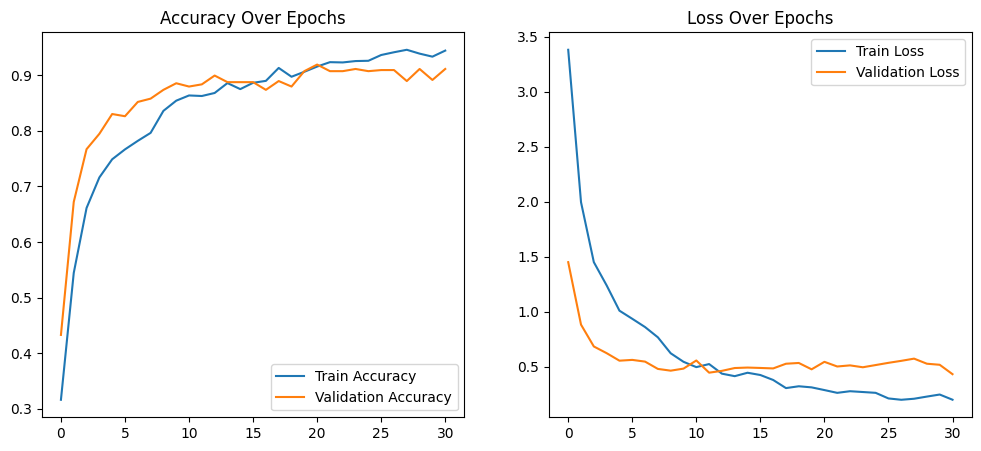

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()